In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2

# Load dataset
df = pd.read_csv("Bengaluru_House_Data.csv")

# Inspect dataset
print("First 5 rows:\n", df.head())
print("\nInfo:\n", df.info())
print("\nSummary statistics:\n", df.describe())
print("\nMissing values per column:\n", df.isnull().sum())


First 5 rows:
               area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null 

In [23]:
# 1️⃣ Drop irrelevant columns
df = df.drop(['area_type','society'], axis=1)

# 2️⃣ Handle missing values (drop rows with essential missing fields)
df = df.dropna(subset=['location','bath','balcony','total_sqft','price'])

# 3️⃣ Convert 'total_sqft' to numeric, handle ranges like '1000-1200'
def convert_sqft(x):
    try:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1]))/2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df = df.dropna(subset=['total_sqft'])

# 4️⃣ Create 'bhk' from total_sqft (approximation: 300 sqft per bedroom)
df['bhk'] = (df['total_sqft']/300).apply(np.floor)

# 5️⃣ Remove outliers
# Price per sqft
df['price_per_sqft'] = df['price']*100000 / df['total_sqft']
df = df[(df['price_per_sqft'] > 1000) & (df['price_per_sqft'] < 20000)]
df = df[df['total_sqft']/df['bhk'] >= 300]

# 6️⃣ Clean location names
df['location'] = df['location'].apply(lambda x: x.strip())
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)

# 7️⃣ One-hot encode locations
dummies = pd.get_dummies(df['location'])
df = pd.concat([df, dummies.drop('other', axis=1)], axis=1)

# 8️⃣ Optional: log-transform price
df['price'] = np.log(df['price'])



Correlation matrix:
                 total_sqft      bath   balcony     price       bhk  \
total_sqft        1.000000  0.509229  0.186742  0.675580  0.994762   
bath              0.509229  1.000000  0.209294  0.632482  0.517624   
balcony           0.186742  0.209294  1.000000  0.202963  0.181919   
price             0.675580  0.632482  0.202963  1.000000  0.679870   
bhk               0.994762  0.517624  0.181919  0.679870  1.000000   
price_per_sqft    0.205123  0.425960  0.031655  0.742461  0.218836   

                price_per_sqft  
total_sqft            0.205123  
bath                  0.425960  
balcony               0.031655  
price                 0.742461  
bhk                   0.218836  
price_per_sqft        1.000000  

Correlation with target (price):
 price             1.000000
price_per_sqft    0.742461
bhk               0.679870
total_sqft        0.675580
bath              0.632482
balcony           0.202963
Name: price, dtype: float64


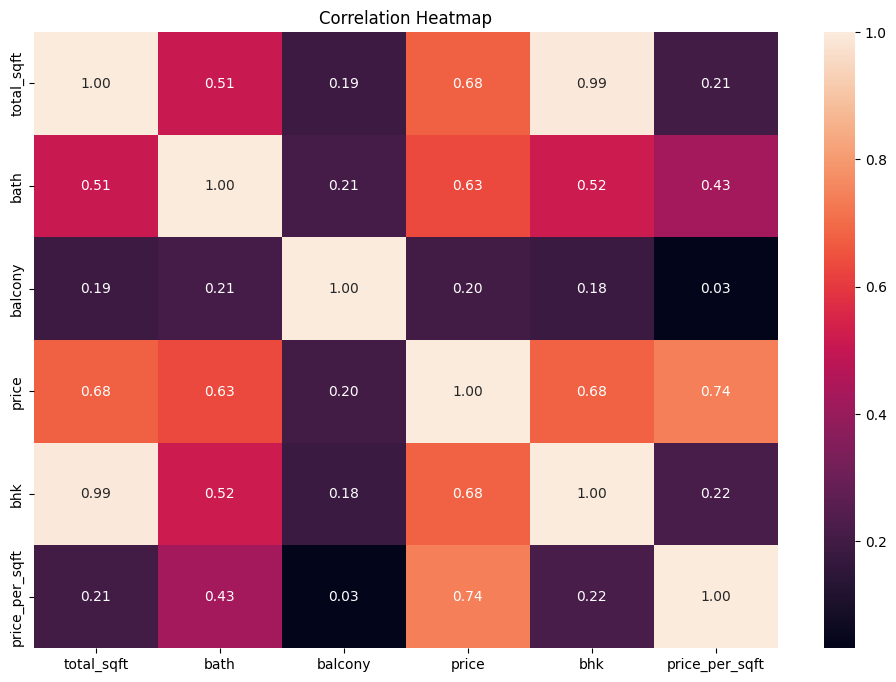

In [24]:
# Select numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Correlation matrix
corr_matrix = numeric_df.corr()
print("\nCorrelation matrix:\n", corr_matrix)

# Sort features by correlation with price
print("\nCorrelation with target (price):\n", numeric_df.corr()['price'].sort_values(ascending=False))

# Heatmap visualization
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [25]:
# === 1️⃣ Proximity Feature: Distance to MG Road ===
mg_road_coords = (12.9756, 77.6047)  # city center

# Major locations with lat/lon (expandable)
location_coords = {
    "Whitefield": (12.9698, 77.7499),
    "Sarjapur Road": (12.8971, 77.6820),
    "Electronic City": (12.8412, 77.6636),
    "Hebbal": (13.0350, 77.5970),
    "Yelahanka": (13.1007, 77.5963),
    "Marathahalli": (12.9592, 77.6974),
    "Indira Nagar": (12.9784, 77.6408),
    "HSR Layout": (12.9121, 77.6446)
}

def haversine(coord1, coord2):
    R = 6371  # Earth radius in km
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def get_distance_to_center(loc):
    if loc in location_coords:
        return haversine(location_coords[loc], mg_road_coords)
    else:
        return np.nan

df["distance_to_center_km"] = df["location"].apply(get_distance_to_center)

# === 2️⃣ Neighborhood Feature: Average price per sqft ===
df["location_avg_price_per_sqft"] = df.groupby("location")["price_per_sqft"].transform('mean')

# === 3️⃣ Temporal Feature: Extract year from 'availability' if exists ===
if "availability" in df.columns:
    df["year"] = df["availability"].apply(lambda x: int(str(x)) if str(x).isdigit() else np.nan)

# Check enriched features
print(df[["location","distance_to_center_km","location_avg_price_per_sqft","year"]].head(10))


                    location  distance_to_center_km  \
0   Electronic City Phase II                    NaN   
1           Chikka Tirupathi                    NaN   
2                Uttarahalli                    NaN   
3         Lingadheeranahalli                    NaN   
4                   Kothanur                    NaN   
5                 Whitefield              15.746636   
8               Marathahalli              10.209090   
10                Whitefield              15.746636   
11                Whitefield              15.746636   
12        7th Phase JP Nagar                    NaN   

    location_avg_price_per_sqft  year  
0                   3718.691663   NaN  
1                   4632.961691   NaN  
2                   4523.535071   NaN  
3                   6613.525331   NaN  
4                   5657.718453   NaN  
5                   6010.042585   NaN  
8                   5972.706221   NaN  
10                  6010.042585   NaN  
11                  6010.042585   

In [26]:
# === Approximate distances (in km) from locations to amenities ===
amenity_distances = {
    "Whitefield": {"school": 1.2, "hospital": 2.5, "metro": 3.0},
    "Sarjapur Road": {"school": 0.8, "hospital": 1.5, "metro": 2.2},
    "Electronic City": {"school": 1.0, "hospital": 2.0, "metro": 3.5},
    "Hebbal": {"school": 1.5, "hospital": 2.0, "metro": 2.0},
    "Yelahanka": {"school": 1.2, "hospital": 1.8, "metro": 2.5},
    "Marathahalli": {"school": 1.0, "hospital": 1.8, "metro": 2.8},
    "Indira Nagar": {"school": 0.5, "hospital": 1.0, "metro": 1.5},
    "HSR Layout": {"school": 0.8, "hospital": 1.2, "metro": 2.0},
    "other": {"school": 2.0, "hospital": 2.5, "metro": 3.0}
}

def get_school_distance(loc):
    return amenity_distances.get(loc, amenity_distances["other"])["school"]

def get_hospital_distance(loc):
    return amenity_distances.get(loc, amenity_distances["other"])["hospital"]

def get_metro_distance(loc):
    return amenity_distances.get(loc, amenity_distances["other"])["metro"]

# Apply functions
df["school_dist_km"] = df["location"].apply(get_school_distance)
df["hospital_dist_km"] = df["location"].apply(get_hospital_distance)
df["metro_dist_km"] = df["location"].apply(get_metro_distance)

# Check new features
print(df[["location","school_dist_km","hospital_dist_km","metro_dist_km"]].head(10))


                    location  school_dist_km  hospital_dist_km  metro_dist_km
0   Electronic City Phase II             2.0               2.5            3.0
1           Chikka Tirupathi             2.0               2.5            3.0
2                Uttarahalli             2.0               2.5            3.0
3         Lingadheeranahalli             2.0               2.5            3.0
4                   Kothanur             2.0               2.5            3.0
5                 Whitefield             1.2               2.5            3.0
8               Marathahalli             1.0               1.8            2.8
10                Whitefield             1.2               2.5            3.0
11                Whitefield             1.2               2.5            3.0
12        7th Phase JP Nagar             2.0               2.5            3.0


In [27]:
# Drop unnecessary columns for modeling
X = df.drop(['price','price_per_sqft','location'], axis=1)
y = df['price']

print("Final feature matrix shape:", X.shape)
print("Features:\n", X.columns)
print("Target sample:\n", y.head())


Final feature matrix shape: (12434, 243)
Features:
 Index(['availability', 'size', 'total_sqft', 'bath', 'balcony', 'bhk',
       '1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       ...
       'Yelahanka', 'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur',
       'distance_to_center_km', 'location_avg_price_per_sqft', 'year',
       'school_dist_km', 'hospital_dist_km', 'metro_dist_km'],
      dtype='object', length=243)
Target sample:
 0    3.665355
1    4.787492
2    4.127134
3    4.553877
4    3.931826
Name: price, dtype: float64


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: XGBoost
try:
    import xgboost as xgb
    use_xgb = True
except:
    print("XGBoost not installed. Skipping XGBoost model.")
    use_xgb = False


In [29]:
# Drop unnecessary columns
X = df.drop(['price', 'price_per_sqft', 'location', 'availability', 'size'], axis=1)
y = df['price']

# Identify numeric features
numeric_features = ['total_sqft', 'bath', 'balcony', 'bhk',
                    'distance_to_center_km', 'location_avg_price_per_sqft',
                    'year', 'school_dist_km', 'hospital_dist_km', 'metro_dist_km']

existing_numeric_features = [col for col in numeric_features if col in X.columns and X[col].notna().any()]
categorical_features = [col for col in X.columns if col not in existing_numeric_features]

# Impute numeric values
numeric_imputer = SimpleImputer(strategy='median')
X[existing_numeric_features] = pd.DataFrame(
    numeric_imputer.fit_transform(X[existing_numeric_features]),
    columns=existing_numeric_features,
    index=X.index
)

# Impute categorical values with 0
if categorical_features:
    categorical_imputer = SimpleImputer(strategy='constant', fill_value=0)
    X[categorical_features] = pd.DataFrame(
        categorical_imputer.fit_transform(X[categorical_features]),
        columns=categorical_features,
        index=X.index
    )

# Scale numeric features for Linear Regression
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[existing_numeric_features] = scaler.fit_transform(X[existing_numeric_features])


c:\Users\abhir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


In [30]:
# For Linear Regression
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# For Tree-based Models
X_train_tree, X_test_tree, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [31]:
from sklearn.model_selection import RandomizedSearchCV

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
}

if use_xgb:
    models["XGBoost"] = xgb.XGBRegressor(random_state=42)

# Reduced parameter grids for faster search
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 150],       # fewer choices
        'max_depth': [10, None],          # limit depth options
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6]
    } if use_xgb else {}
}

# Use RandomizedSearchCV for faster tuning
tuned_models = {}
for name, model in models.items():
    if name in param_grids:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=4,             # only 4 random combinations
            cv=3,                 # 3-fold cross-validation
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train_tree, y_train)
        tuned_models[name] = random_search.best_estimator_
        print(f"Best parameters for {name}: {random_search.best_params_}")
    else:
        tuned_models[name] = model


Best parameters for Random Forest: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 10}
Best parameters for XGBoost: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1}


In [32]:
# -----------------------------
# 4️⃣ Train, Predict & Evaluate
# -----------------------------
results = {}
predictions = {}

for name, model in tuned_models.items():
    # Choose scaled features for Linear Regression, raw features for tree-based models
    if name == "Linear Regression":
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train_tree, X_test_tree

    # Train the model
    model.fit(X_tr, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_te)
    predictions[name] = y_pred
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

# -----------------------------
# 5️⃣ Display Evaluation Metrics
# -----------------------------
print("Model Evaluation Metrics:\n")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R²']:.4f}")


Model Evaluation Metrics:

Linear Regression: RMSE=0.4046, MAE=0.2847, R²=0.6170
Random Forest: RMSE=0.3081, MAE=0.2292, R²=0.7778
XGBoost: RMSE=0.3064, MAE=0.2287, R²=0.7802


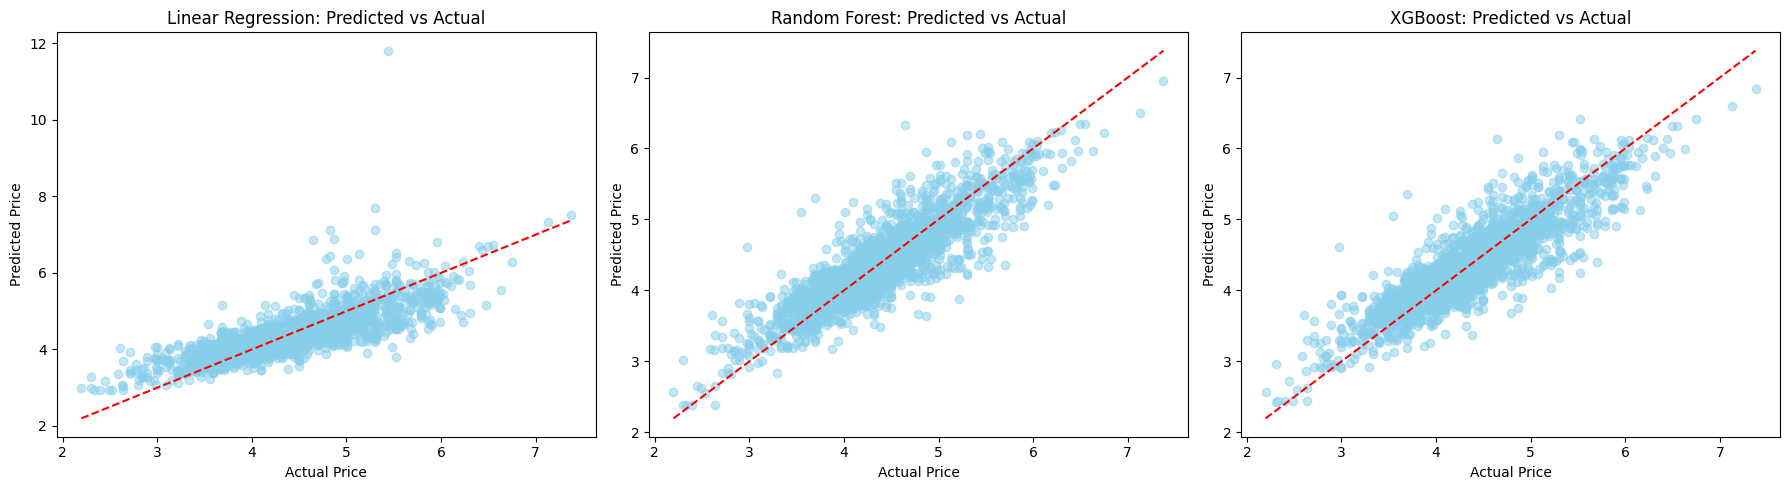

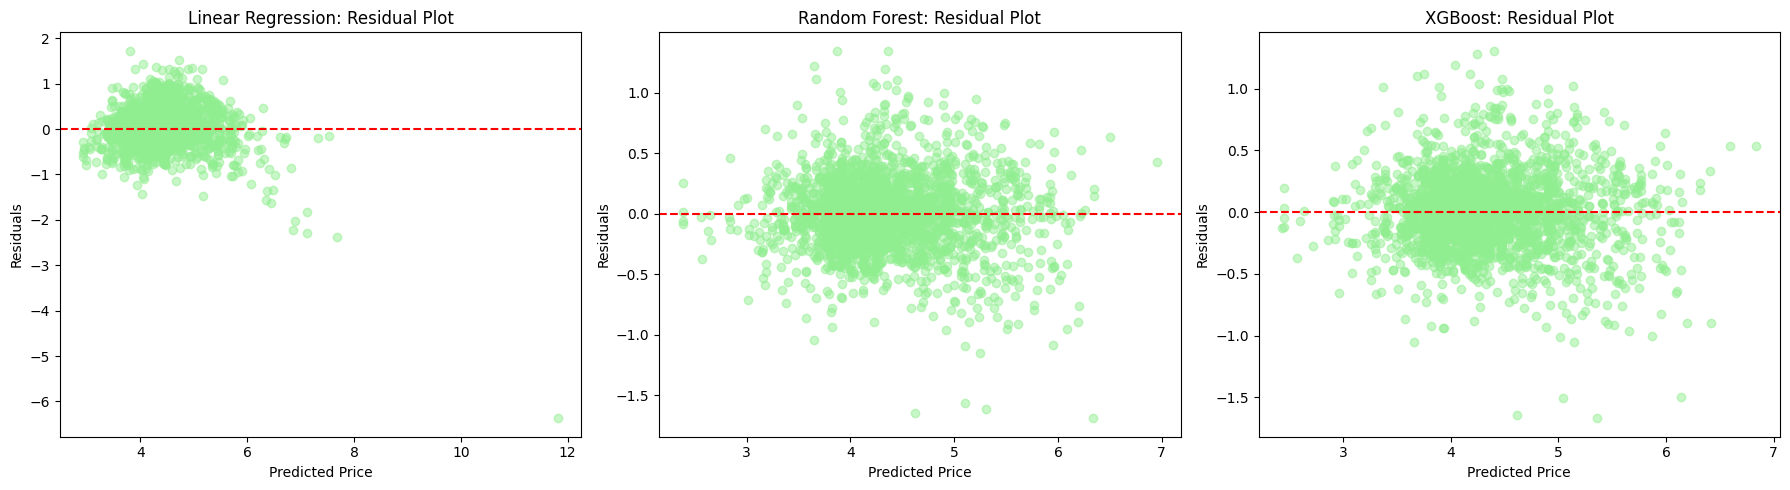

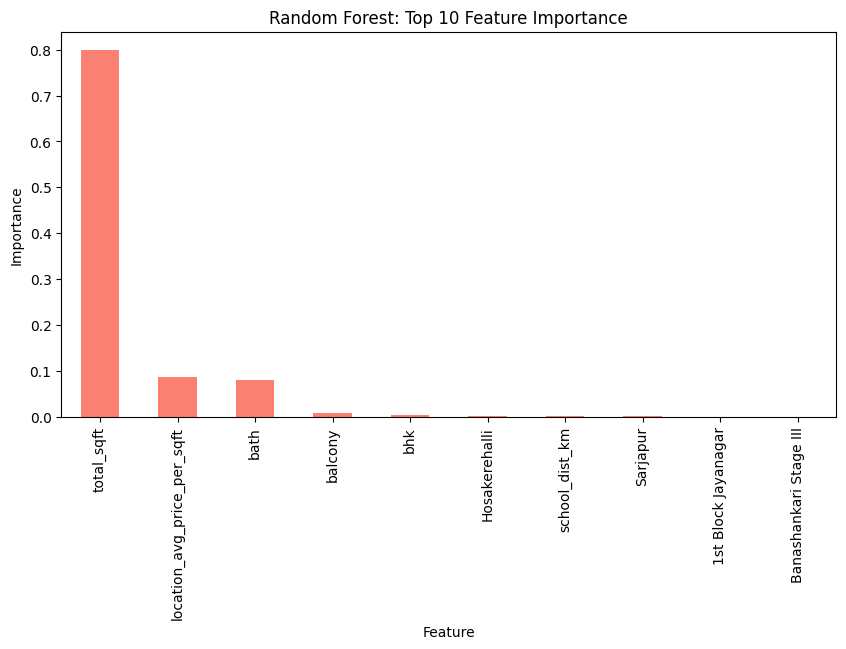

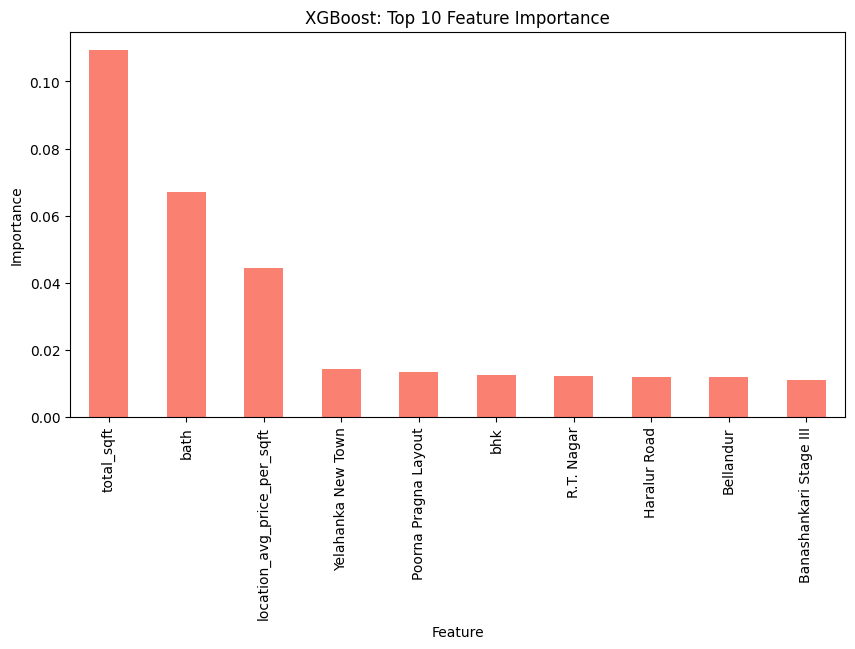

In [33]:
# -----------------------------
# 6️⃣ Predicted vs Actual Plot
# -----------------------------
plt.figure(figsize=(18,5))
for i, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(1, len(predictions), i)
    plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name}: Predicted vs Actual")
plt.tight_layout()
plt.show()

# -----------------------------
# 7️⃣ Residual Plot
# -----------------------------
plt.figure(figsize=(18,5))
for i, (name, y_pred) in enumerate(predictions.items(), 1):
    residuals = y_test - y_pred
    plt.subplot(1, len(predictions), i)
    plt.scatter(y_pred, residuals, alpha=0.5, color='lightgreen')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title(f"{name}: Residual Plot")
plt.tight_layout()
plt.show()

# -----------------------------
# 8️⃣ Feature Importance for Tree-Based Models
# -----------------------------
for name, model in tuned_models.items():
    if name != "Linear Regression":
        importances = pd.Series(model.feature_importances_, index=X.columns)
        top_features = importances.sort_values(ascending=False)[:10]
        plt.figure(figsize=(10,5))
        top_features.plot(kind='bar', color='salmon')
        plt.title(f"{name}: Top 10 Feature Importance")
        plt.ylabel("Importance")
        plt.xlabel("Feature")
        plt.show()


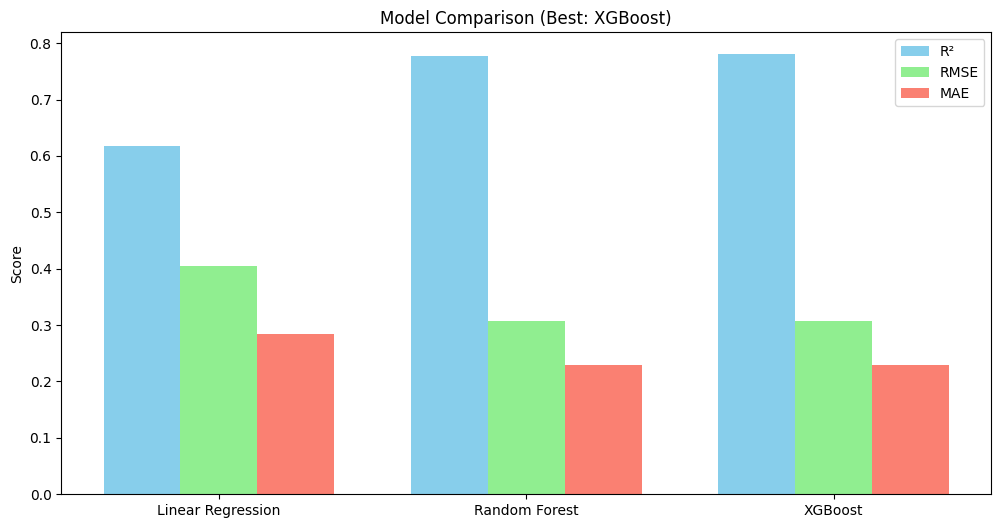


✅ Best Model Based on R²: XGBoost
R² = 0.7802, RMSE = 0.3064, MAE = 0.2287


In [34]:
# -----------------------------
# 9️⃣ Model Comparison and Best Model
# -----------------------------

# Extract R², RMSE, MAE for comparison
model_names = list(results.keys())
r2_scores = [results[name]['R²'] for name in model_names]
rmse_scores = [results[name]['RMSE'] for name in model_names]
mae_scores = [results[name]['MAE'] for name in model_names]

# Identify best model based on R²
best_model_index = np.argmax(r2_scores)
best_model_name = model_names[best_model_index]

plt.figure(figsize=(12,6))
bar_width = 0.25
x = np.arange(len(model_names))

# R² bars
plt.bar(x - bar_width, r2_scores, width=bar_width, color='skyblue', label='R²')
# RMSE bars
plt.bar(x, rmse_scores, width=bar_width, color='lightgreen', label='RMSE')
# MAE bars
plt.bar(x + bar_width, mae_scores, width=bar_width, color='salmon', label='MAE')

# Labels
plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title(f"Model Comparison (Best: {best_model_name})")
plt.legend()
plt.show()

print(f"\n✅ Best Model Based on R²: {best_model_name}")
print(f"R² = {r2_scores[best_model_index]:.4f}, RMSE = {rmse_scores[best_model_index]:.4f}, MAE = {mae_scores[best_model_index]:.4f}")


 99%|===================| 2455/2487 [00:15<00:00]        

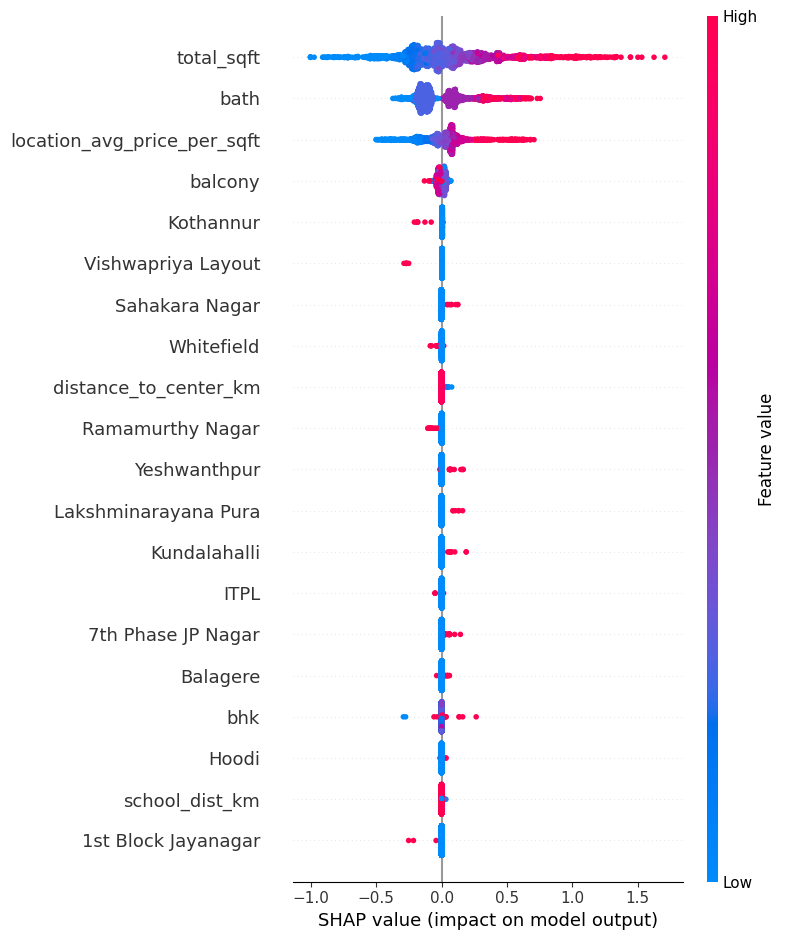

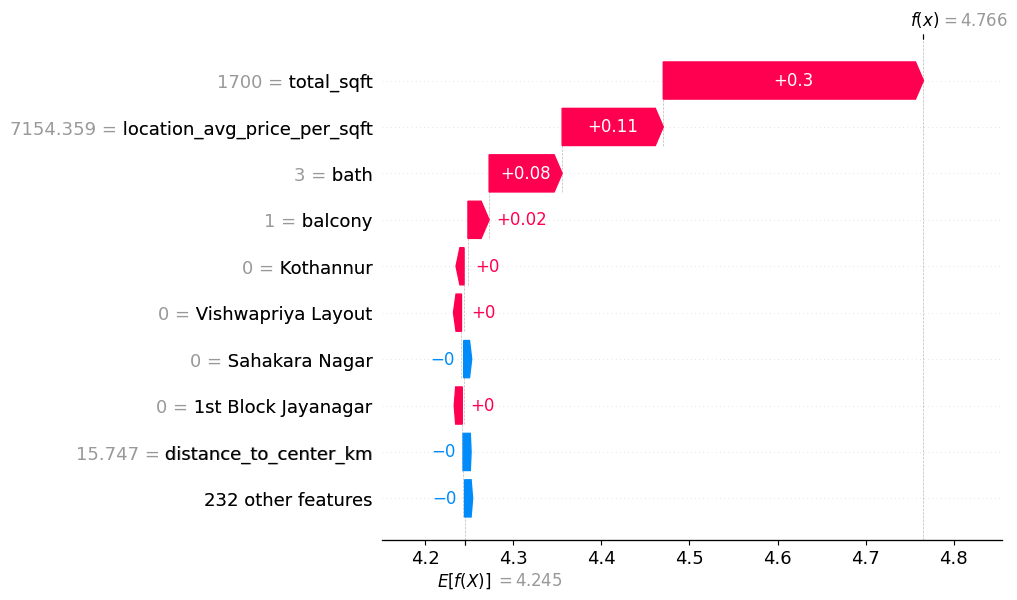

📌 Prediction explanation for house 0:
 - total_sqft = 1700.0 increases the price (SHAP: +0.30).
 - location_avg_price_per_sqft = 7154.358716817041 increases the price (SHAP: +0.11).
 - bath = 3.0 increases the price (SHAP: +0.08).

✅ Overall, price is pushed UP by total_sqft, location_avg_price_per_sqft and pushed DOWN by Sahakara Nagar, distance_to_center_km.


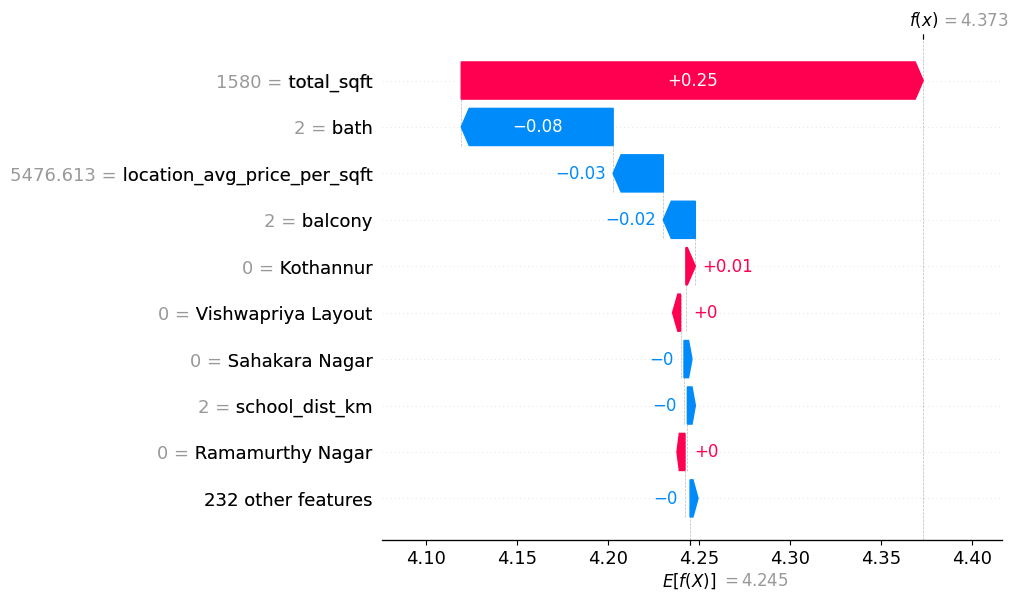

📌 Prediction explanation for house 1:
 - total_sqft = 1580.0 increases the price (SHAP: +0.25).
 - bath = 2.0 decreases the price (SHAP: -0.08).
 - location_avg_price_per_sqft = 5476.61280359046 decreases the price (SHAP: -0.03).

✅ Overall, price is pushed UP by total_sqft, Kothannur and pushed DOWN by bath, location_avg_price_per_sqft.


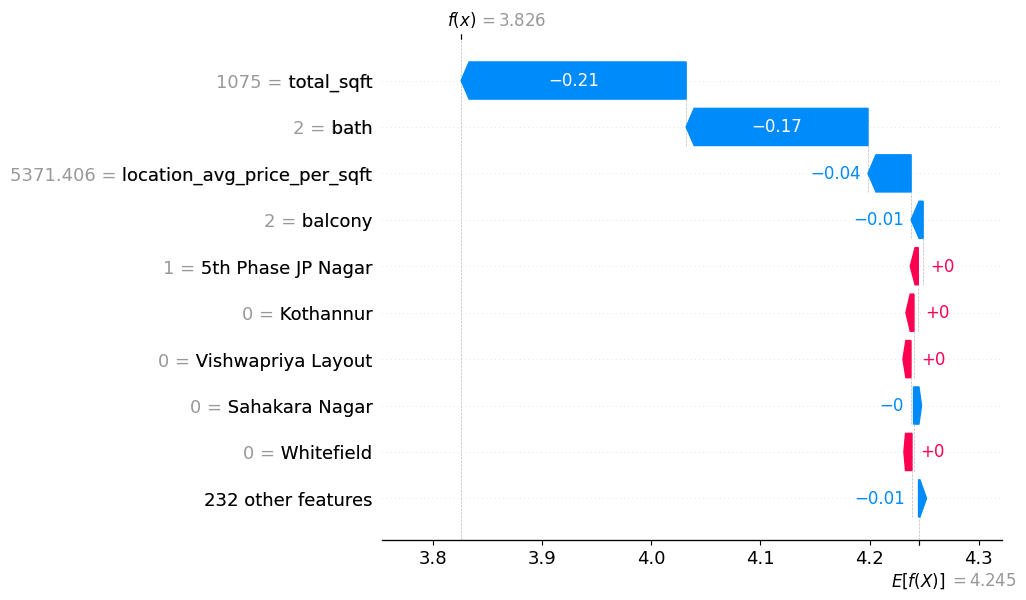

📌 Prediction explanation for house 2:
 - total_sqft = 1075.0 decreases the price (SHAP: -0.21).
 - bath = 2.0 decreases the price (SHAP: -0.17).
 - location_avg_price_per_sqft = 5371.405503011989 decreases the price (SHAP: -0.04).

✅ Overall, price is pushed UP by 5th Phase JP Nagar, Kothannur and pushed DOWN by total_sqft, bath.


In [36]:
# -----------------------------
# 🔎 SHAP Explainability with Text Explanations
# -----------------------------
import shap

# Pick the best model from tuned models
best_model = tuned_models[best_model_name]

# Select the right test dataset
if best_model_name == "Linear Regression":
    X_test_used = X_test_scaled
elif best_model_name in ["Random Forest", "XGBoost"]:
    X_test_used = X_test_tree
else:
    X_test_used = X_test_tree  # fallback

# -----------------------------
# Helper: Generate explanation text
# -----------------------------
def generate_explanation(shap_values, X_test_used, index, top_n=3):
    """
    Generate a natural language explanation for a prediction based on SHAP values.
    
    Args:
        shap_values: SHAP values for test set
        X_test_used: Feature dataframe used for SHAP
        index: row index from test set
        top_n: number of top positive/negative features to explain
    
    Returns:
        explanation string
    """
    # Extract shap values for this row
    row_shap = shap_values[index].values
    row_features = X_test_used.iloc[index]

    # Pair feature names with SHAP values
    feature_contributions = list(zip(X_test_used.columns, row_shap, row_features))

    # Sort by absolute SHAP importance
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top_n drivers
    top_features = feature_contributions[:top_n]

    explanation = f"📌 Prediction explanation for house {index}:\n"
    for feature, shap_val, actual_val in top_features:
        if shap_val > 0:
            explanation += f" - {feature} = {actual_val} increases the price (SHAP: +{shap_val:.2f}).\n"
        else:
            explanation += f" - {feature} = {actual_val} decreases the price (SHAP: {shap_val:.2f}).\n"

    # Add summary
    pos_features = [f for f, v, _ in feature_contributions if v > 0]
    neg_features = [f for f, v, _ in feature_contributions if v < 0]

    if pos_features and neg_features:
        explanation += f"\n✅ Overall, price is pushed UP by {', '.join(pos_features[:2])} and pushed DOWN by {', '.join(neg_features[:2])}."
    elif pos_features:
        explanation += f"\n✅ Overall, price is mainly pushed UP by {', '.join(pos_features[:2])}."
    elif neg_features:
        explanation += f"\n✅ Overall, price is mainly pushed DOWN by {', '.join(neg_features[:2])}."

    return explanation


# -----------------------------
# Run SHAP Explainability
# -----------------------------
try:
    # Build SHAP explainer
    explainer = shap.Explainer(best_model, X_test_used)
    shap_values = explainer(X_test_used)

    # ✅ Global explanation
    shap.summary_plot(shap_values, X_test_used, feature_names=X_test_used.columns)

    # ✅ Local explanations for first 3 houses
    for i in range(3):
        shap.plots.waterfall(shap_values[i], max_display=10)
        print(generate_explanation(shap_values, X_test_used, index=i, top_n=3))

except Exception as e:
    print("SHAP explanation could not be generated:", e)


In [38]:
import joblib

# Save the trained model
joblib.dump(best_model, "best_model.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save the list of feature columns used during training
joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']